In [1]:
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import copy
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import numpy as np
import seaborn as sns
import scipy
from scipy.optimize import curve_fit
from IPython.display import display, Math
from tqdm import tqdm

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile, epoch_folding_search, z_n_search
from stingray.pulse.pulsar import fold_events
import stingray.gti as sting_gti
import stingray.pulse.accelsearch as accelsearch
from stingray import stats
from stingray.deadtime import fad


sns.set_context('paper')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_style({'axes.edgecolor': 'black', 'xick.bottom': True, 'ytick.left':True})
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

root_dir = '/Volumes/Samsung_1TB/AstroData/MAXI_J0655m013/'

def gaussian(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))


/Users/sean/miniconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/miniconda3/lib/python3.9/site-packages/stingray/utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [2]:
OBSID='90801321001'
pipeline_dir = root_dir + OBSID + '_pipe_out/'
products_dir = root_dir + OBSID + '_products/'
plot_dir = root_dir + 'figures/'

# Light-curve

In [3]:
src_lc_A = fits.open(products_dir + 'nu' + OBSID + 'A01_sr.lc')[1].data
bkg_lc_A = fits.open(products_dir + 'nu' + OBSID + 'A01_bk.lc')[1].data
src_lc_B = fits.open(products_dir + 'nu' + OBSID + 'B01_sr.lc')[1].data
bkg_lc_B = fits.open(products_dir + 'nu' + OBSID + 'B01_bk.lc')[1].data

# same_time_B = [t in src_lc_A['TIME'] for t in src_lc_B['TIME']]
# same_time_A = [t in src_lc_B['TIME'] for t in src_lc_A['TIME']]

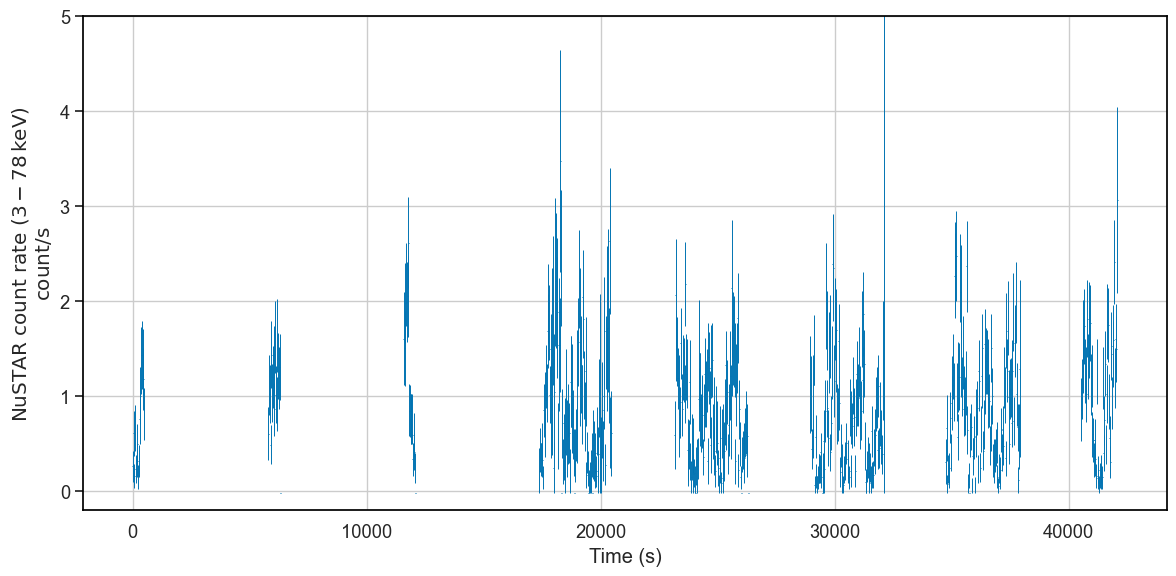

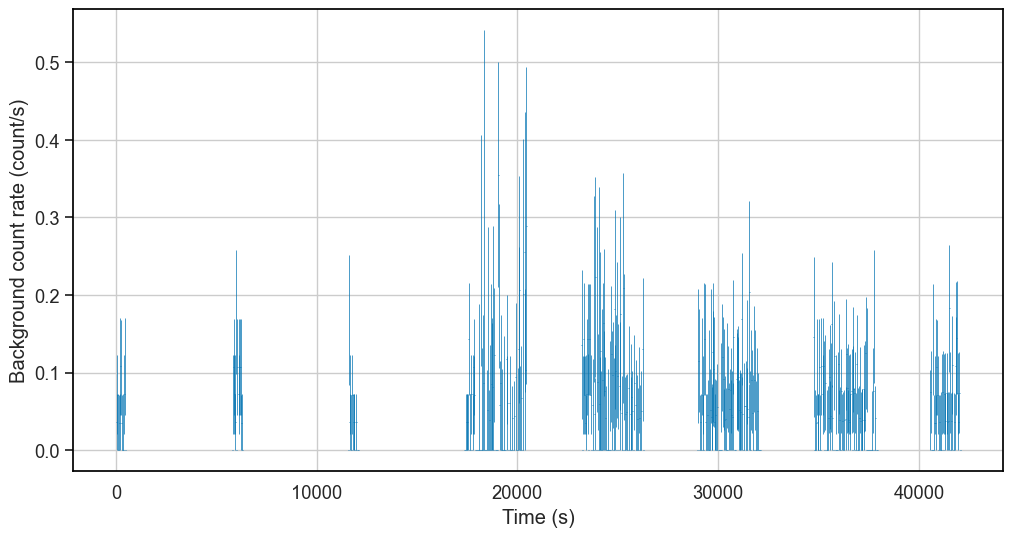

In [4]:
area_ratio = np.square(2./3.)
plt.figure(figsize = (12, 6))
plt.errorbar(src_lc_A['TIME'], (src_lc_A['RATE'] + src_lc_B['RATE'])-(area_ratio*(np.mean(bkg_lc_A['RATE']) + np.mean(bkg_lc_B['RATE']))), xerr=16, yerr=np.sqrt(np.square(src_lc_A['ERROR']) + np.square(src_lc_B['ERROR'])), ls='', lw=0.7)
plt.ylim((-0.2, 5))

plt.ylabel(r'$\mathrm{NuSTAR\ count\ rate\ (3-78\,keV)}$' + '\n' + r'$\mathrm{count/s}$')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_lc_fpma+fpmb.pdf')

plt.figure(figsize = (12, 6))
plt.errorbar(bkg_lc_A['TIME'], (bkg_lc_A['RATE'] + bkg_lc_B['RATE']), xerr=16, yerr=np.sqrt(np.square(bkg_lc_A['ERROR']) + np.square(bkg_lc_B['ERROR'])), ls='', lw=0.5)

plt.ylabel('Background count rate (count/s)')
plt.xlabel('Time (s)')

plt.savefig(plot_dir + OBSID + '_lc_fpma+fpmb_bkg.pdf')


In [83]:
PI_min = eV_to_PI(3000)     # 3.0 keV
PI_max = eV_to_PI(78000)   # 78.0 keV

TSTART = 3.935466220000000E+08

for fpm in ['A', 'B']:
    plt.figure(figsize=(20,6))
    lcurve_ax = plt.gca()
    for chu in chu_combos:
        print('chu' + chu)

        src_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+fpm + '06_chu' + chu + '_S_sr.lc')
        bkg_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+fpm + '06_chu' + chu + '_S_bk.lc')

        area_ratio = np.square(src_lc.radius/bkg_lc.radius)

        lcurve_ax.errorbar(src_lc.time-TSTART, src_lc.countrate-(bkg_lc.meanrate*area_ratio), xerr=src_lc.dt/2, yerr=src_lc.countrate_err, ls='', label = 'CHU'+str(chu))


    lcurve_ax.set_xlabel('Time (s)')
    lcurve_ax.set_ylabel('FPM' + fpm + r'$\ \mathrm{\ count\ rate\ (3-78\,keV)}$')
    lcurve_ax.legend()
    plt.tight_layout()
    plt.savefig(plot_dir + OBSID + '_lc_chusplit_FPM' + fpm + '.pdf')
    plt.close()
    
plt.figure(figsize=(20,6))
lcurve_ax = plt.gca()
for chu in chu_combos:
    print('chu' + chu)

    chu_start = fits.open(products_dir + 'nu80801347002A06_chu' + chu + '_S_sr.lc')[0].header['TSTART'] - TSTART
    src_lc_A = fits.open(products_dir + 'nu80801347002A06_chu' + chu + '_S_sr.lc')[1].data
    bkg_lc_A = fits.open(products_dir + 'nu80801347002A06_chu' + chu + '_S_bk.lc')[1].data
    src_lc_B = fits.open(products_dir + 'nu80801347002B06_chu' + chu + '_S_sr.lc')[1].data
    bkg_lc_B = fits.open(products_dir + 'nu80801347002B06_chu' + chu + '_S_bk.lc')[1].data
    same_time_B = [t in src_lc_A['TIME'] for t in src_lc_B['TIME']]
    same_time_A = [t in src_lc_B['TIME'] for t in src_lc_A['TIME']]
    lcurve_ax.errorbar(src_lc_A['TIME'][same_time_A] + chu_start, (src_lc_A['RATE'][same_time_A] + src_lc_B['RATE'][same_time_B])-(area_ratio*(np.mean(bkg_lc_A['RATE']) + np.mean(bkg_lc_B['RATE']))), \
                       xerr=5, yerr=np.sqrt(np.square(src_lc_A['ERROR'][same_time_A]) + np.square(src_lc_B['ERROR'][same_time_B])), ls='', label = 'CHU'+str(chu))


lcurve_ax.set_xlabel('Time (s)')
lcurve_ax.set_ylabel(r'$\mathrm{NuSTAR\ count\ rate\ (3-78\,keV)}$' + '\n' + r'$\mathrm{count/s}$')
lcurve_ax.legend()
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_lc_chusplit_fpma+fpmb.pdf')
plt.close()

chu12
chu23
chu13
chu123
chu1
chu2
chu12
chu23
chu13
chu123
chu1
chu2
chu12
chu23
chu13
chu123
chu1
chu2


# Z_n search

In [5]:
events = extract_events(pipeline_dir + 'nu' + OBSID + 'A01_cl_bc_srcreg_3-78keV.evt', pipeline_dir + 'nu' + OBSID + 'B01_cl_bc_srcreg_3-78keV.evt')
all_times = np.sort(np.concatenate([events[0].time, events[1].time]))
# print(events[0].gti.T[1]-events[0].gti.T[0])
# fad_pds = fad.FAD(events[0], events[1], segment_size=3000, dt=1.0/2048., norm='leahy')

28.913443830570902 +/- 4.108118173557375
1114.0155924751607 +\- 0.06897745968351754
0.0008976535039138576 +\- 5.5580782526046156e-08


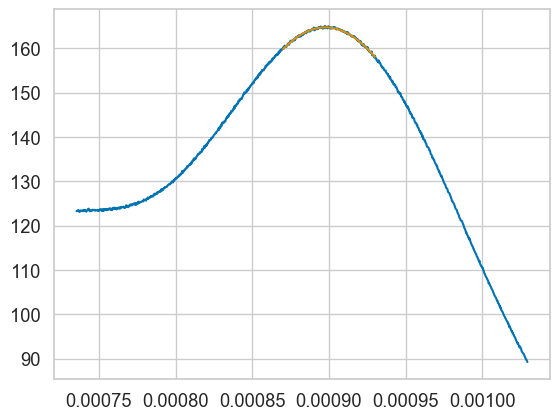

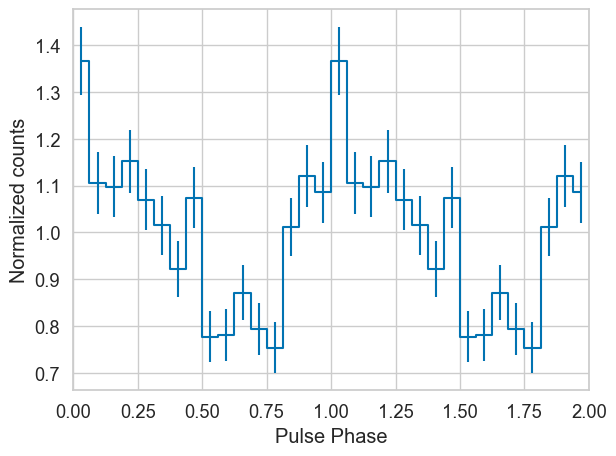

In [4]:
search_freqs = np.linspace(0.0007352941176470588, 0.0010294117647058822, 1000)
fgrid, z_n_stats = z_n_search(all_times, frequencies=search_freqs, nharm=1)

# z_n_prob = stats.z2_n_logprobability(z_n_stats, n=4, ntrial=len(fgrid))
fit_mask = (fgrid > 0.00087) * (fgrid < 0.00093)
popt, pcov = curve_fit(gaussian,fgrid[fit_mask],z_n_stats[fit_mask],p0=[160, 0.00090,0.00003])
plt.figure()
plt.plot(fgrid, z_n_stats)
plt.plot(fgrid[fit_mask], gaussian(fgrid, *popt)[fit_mask])

plt.figure()
phase_bins, profile, profile_err = fold_events(all_times, [popt[1]], nbin=16)
plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
plt.ylabel('Normalized counts')
plt.xlabel('Pulse Phase')
plt.xlim(0.,2.)
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_pulseprofile_1harm.pdf')

print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))
print(str(1/popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]/(popt[1]*popt[1])))
print(str(popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]))

68.34532374100719 +/- 3.0958654032193604
1082.7519762324573 +\- 0.45605269198899634
0.0009235725465767321 +\- 3.8900667499038016e-07


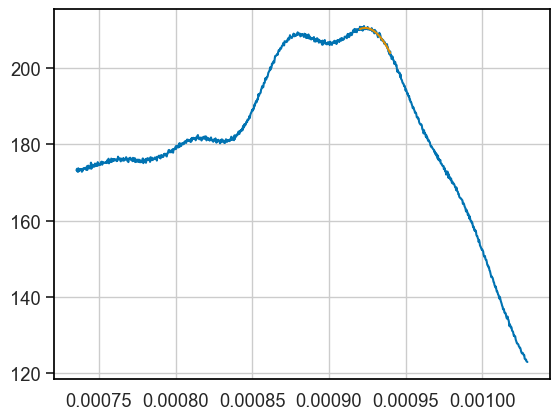

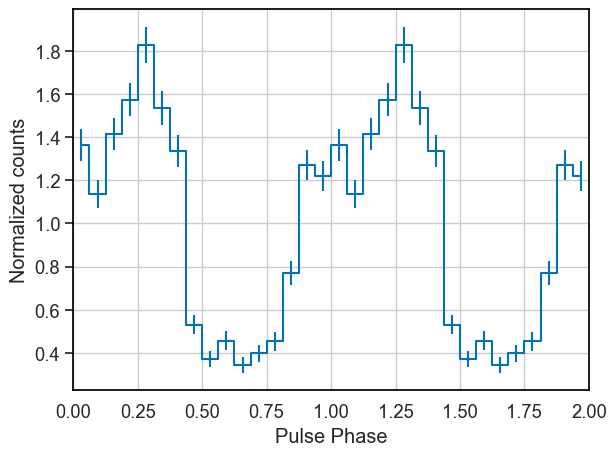

In [6]:
search_freqs = np.linspace(0.0007352941176470588, 0.0010294117647058822, 1000)
fgrid, z_n_stats = z_n_search(all_times, frequencies=search_freqs, nharm=4)

fit_mask = (fgrid > 0.00092) * (fgrid < 0.00094)

popt, pcov = curve_fit(gaussian,fgrid[fit_mask],z_n_stats[fit_mask],p0=[160, 0.00090,0.00003])
plt.figure()
plt.plot(fgrid, z_n_stats)
plt.plot(fgrid[fit_mask], gaussian(fgrid, *popt)[fit_mask])

plt.figure()
phase_bins, profile, profile_err = fold_events(all_times, [popt[1]], nbin=16)
plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
plt.ylabel('Normalized counts')
plt.xlabel('Pulse Phase')
plt.xlim(0.,2.)
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm.pdf')

print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))
print(str(1/popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]/(popt[1]*popt[1])))
print(str(popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]))

68.34532374100719 +/- 3.0958654032193604
69.59619952494062 +/- 3.4997010431142472
70.94017094017094 +/- 6.515918802243484
78.94736842105263 +/- 14.081180085472395


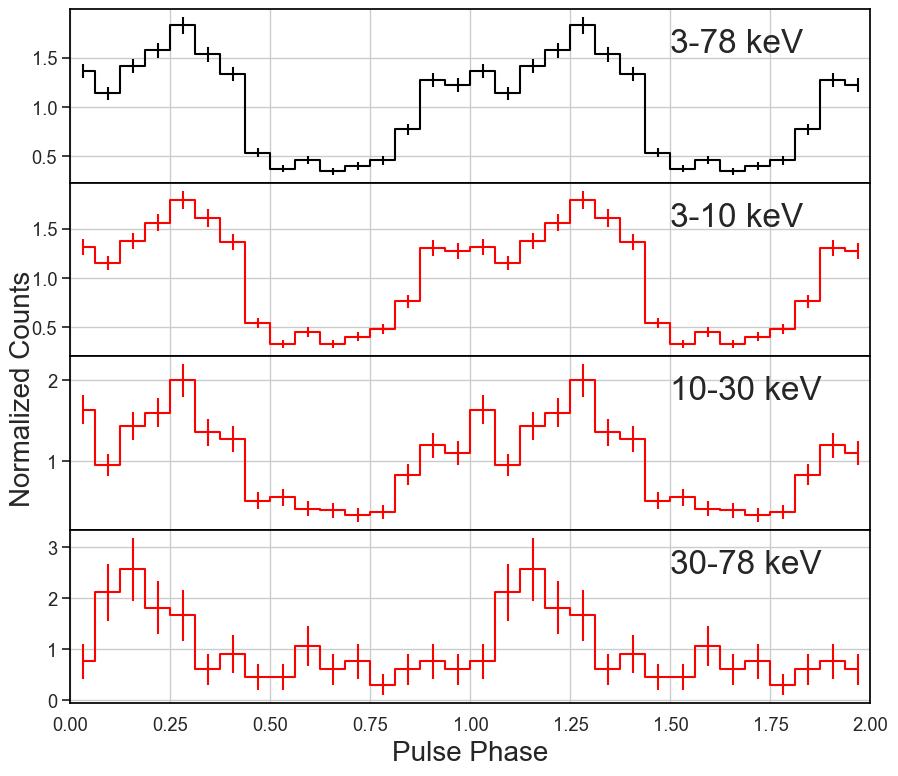

In [7]:
energy_bins = [[3,78], [3,10], [10,30], [30,78]]

fig, axes = plt.subplots(len(energy_bins), 1, figsize = (9, 2*len(energy_bins)), gridspec_kw={'hspace':0}, sharex=True)

for i in range(len(energy_bins)):
    e=energy_bins[i]
    color='red'
    if i==0:
        color='black'
    energy_mask_A = (events[0].pi >= eV_to_PI(1000*e[0])) * (events[0].pi < eV_to_PI(1000*e[1]))
    energy_mask_B = (events[1].pi >= eV_to_PI(1000*e[0])) * (events[1].pi < eV_to_PI(1000*e[1]))
    temp_times = np.sort(np.concatenate([events[0].time[energy_mask_A], events[1].time[energy_mask_B]]))
    
    phase_bins, profile, profile_err = fold_events(temp_times, [popt[1]], nbin=16)
    axes[i].errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color=color)
    axes[i].step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color=color)
    axes[i].text(0.75, 0.75, str(e[0]) + '-' + str(e[1]) + ' keV', transform=axes[i].transAxes, fontsize=24)
    
    print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))

fig.text(0., 0.5, 'Normalized Counts', va='center', rotation='vertical', fontsize=20)
axes[-1].set_xlabel('Pulse Phase', fontsize=20)
axes[-1].set_xlim(0.,2.)
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm_Esplit.pdf')

68.34532374100719 +/- 3.0958654032193604
69.59619952494062 +/- 3.4997010431142472
70.94017094017094 +/- 6.515918802243484
78.94736842105263 +/- 14.081180085472395


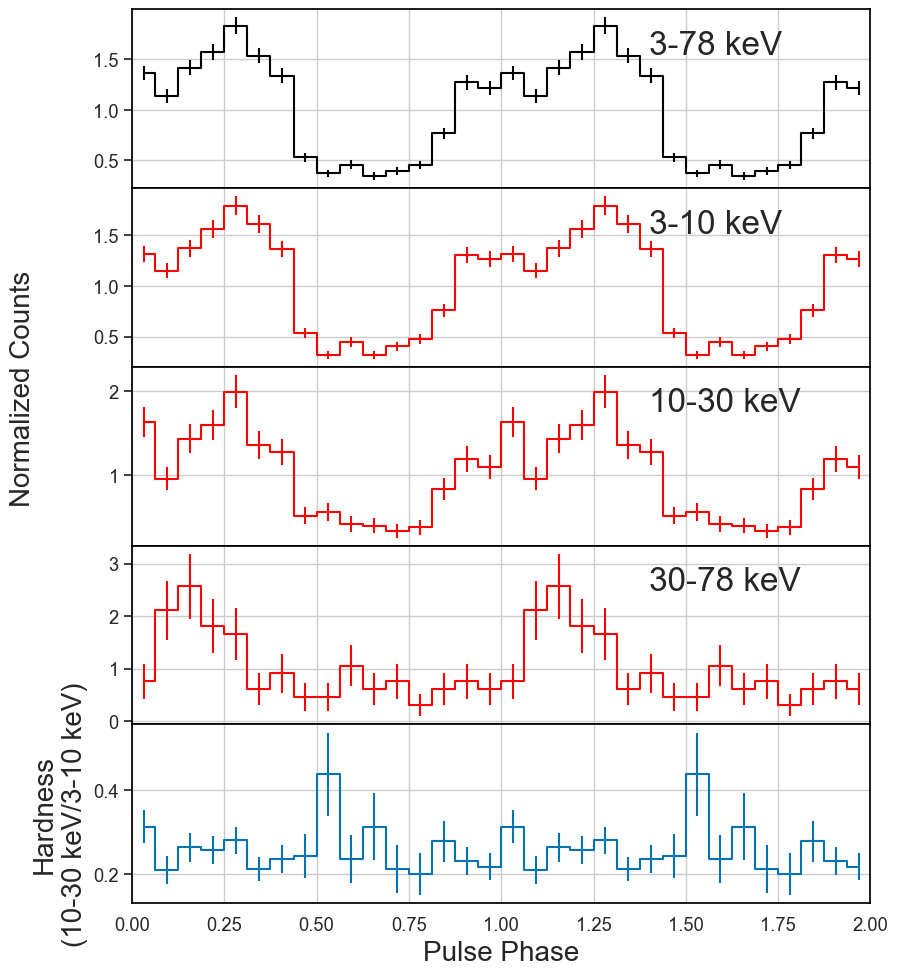

In [9]:
energy_bins = [[3,78], [3,10], [10,30], [30,78]]

fig, axes = plt.subplots(len(energy_bins)+1, 1, figsize = (9, 2*(len(energy_bins)+1)), gridspec_kw={'hspace':0}, sharex=True)

for i in range(len(energy_bins)):
    e=energy_bins[i]
    color='red'
    if i==0:
        color='black'
    energy_mask_A = (events[0].pi >= eV_to_PI(1000*e[0])) * (events[0].pi < eV_to_PI(1000*e[1]))
    energy_mask_B = (events[1].pi >= eV_to_PI(1000*e[0])) * (events[1].pi < eV_to_PI(1000*e[1]))
    temp_times = np.sort(np.concatenate([events[0].time[energy_mask_A], events[1].time[energy_mask_B]]))
    
    phase_bins, profile, profile_err = fold_events(temp_times, [popt[1]], nbin=16)
    axes[i].errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color=color)
    axes[i].step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color=color)
    axes[i].text(0.7, 0.75, str(e[0]) + '-' + str(e[1]) + ' keV', transform=axes[i].transAxes, fontsize=24)
    
    print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))

energy_mask_A_low = (events[0].pi >= eV_to_PI(1000*3.0)) * (events[0].pi < eV_to_PI(1000*10.0))
energy_mask_B_low = (events[1].pi >= eV_to_PI(1000*3.0)) * (events[1].pi < eV_to_PI(1000*10.0))

energy_mask_A_high = (events[0].pi >= eV_to_PI(1000*10.0)) * (events[0].pi < eV_to_PI(1000*30.0))
energy_mask_B_high = (events[1].pi >= eV_to_PI(1000*10.0)) * (events[1].pi < eV_to_PI(1000*30.0))

times_low = np.sort(np.concatenate([events[0].time[energy_mask_A_low], events[1].time[energy_mask_B_low]]))
times_high = np.sort(np.concatenate([events[0].time[energy_mask_A_high], events[1].time[energy_mask_B_high]]))

phase_bins_high, profile_high, profile_err_high = fold_events(times_high, [popt[1]], nbin=16)
phase_bins_low, profile_low, profile_err_low = fold_events(times_low, [popt[1]], nbin=16)
hardness_profile =  profile_high/profile_low
hardness_profile_err =  hardness_profile*np.sqrt(np.square(profile_err_high/profile_high) + np.square(profile_err_low/profile_low))
axes[-1].errorbar(np.concatenate([phase_bins_low, phase_bins_low+1]), np.concatenate([hardness_profile,hardness_profile]), \
                 yerr=np.concatenate([hardness_profile_err,hardness_profile_err]), fmt='', ls='', color='C0')
axes[-1].step(np.concatenate([phase_bins_low, phase_bins_low+1]), np.concatenate([hardness_profile,hardness_profile]), where='mid', color='C0')
    
    
fig.text(0.0, 0.6, 'Normalized Counts', va='center', rotation='vertical', fontsize=20)
axes[-1].set_xlabel('Pulse Phase', fontsize=20)
axes[-1].set_ylabel('Hardness\n(10-30 keV/3-10 keV)', fontsize=20)
axes[-1].set_xlim(0.,2.)
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm_Esplit_hardness.pdf')

Text(0.5, 0, 'Spin up (Pdot)')

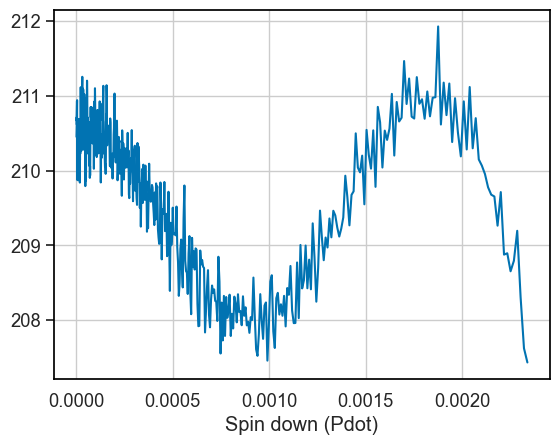

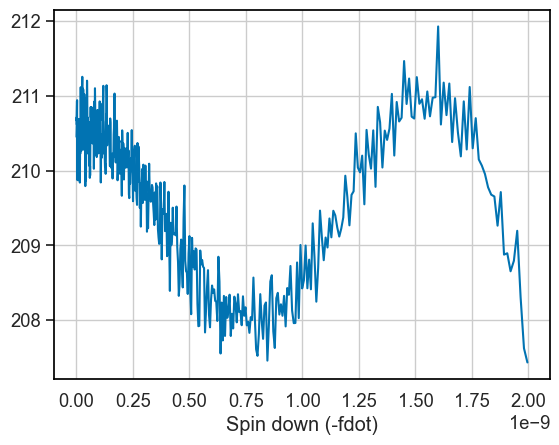

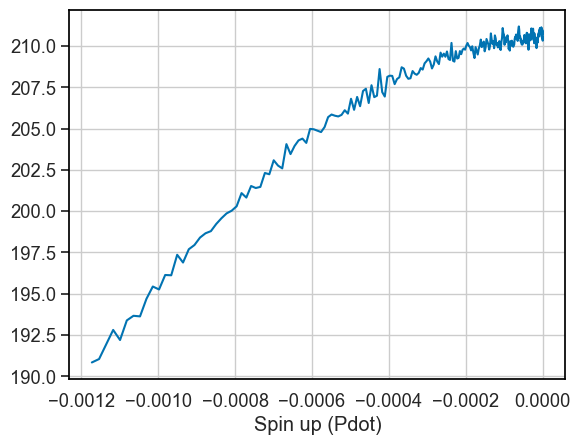

In [49]:
fgrid, fdgrid, z_n_stats = z_n_search(all_times, frequencies=popt[1], fdots=np.concatenate([[0.0], -1*np.logspace(-12, -8.7, 1000)]), nharm=4)

plt.figure()
plt.plot(-fdgrid/np.square(fgrid), z_n_stats)
plt.xlabel('Spin down (Pdot)')
# plt.xscale('log')

plt.figure()
plt.plot(-fdgrid, z_n_stats)
plt.xlabel('Spin down (-fdot)')
# plt.xscale('log')


fgrid, fdgrid, z_n_stats = z_n_search(all_times, frequencies=popt[1], fdots=np.logspace(-16, -9, 1000), nharm=4)

plt.figure()
plt.plot(-fdgrid/np.square(fgrid), z_n_stats)
plt.xlabel('Spin up (Pdot)')
# plt.xscale('log')
